Abtastrate: 2428.5476210315805 Hz


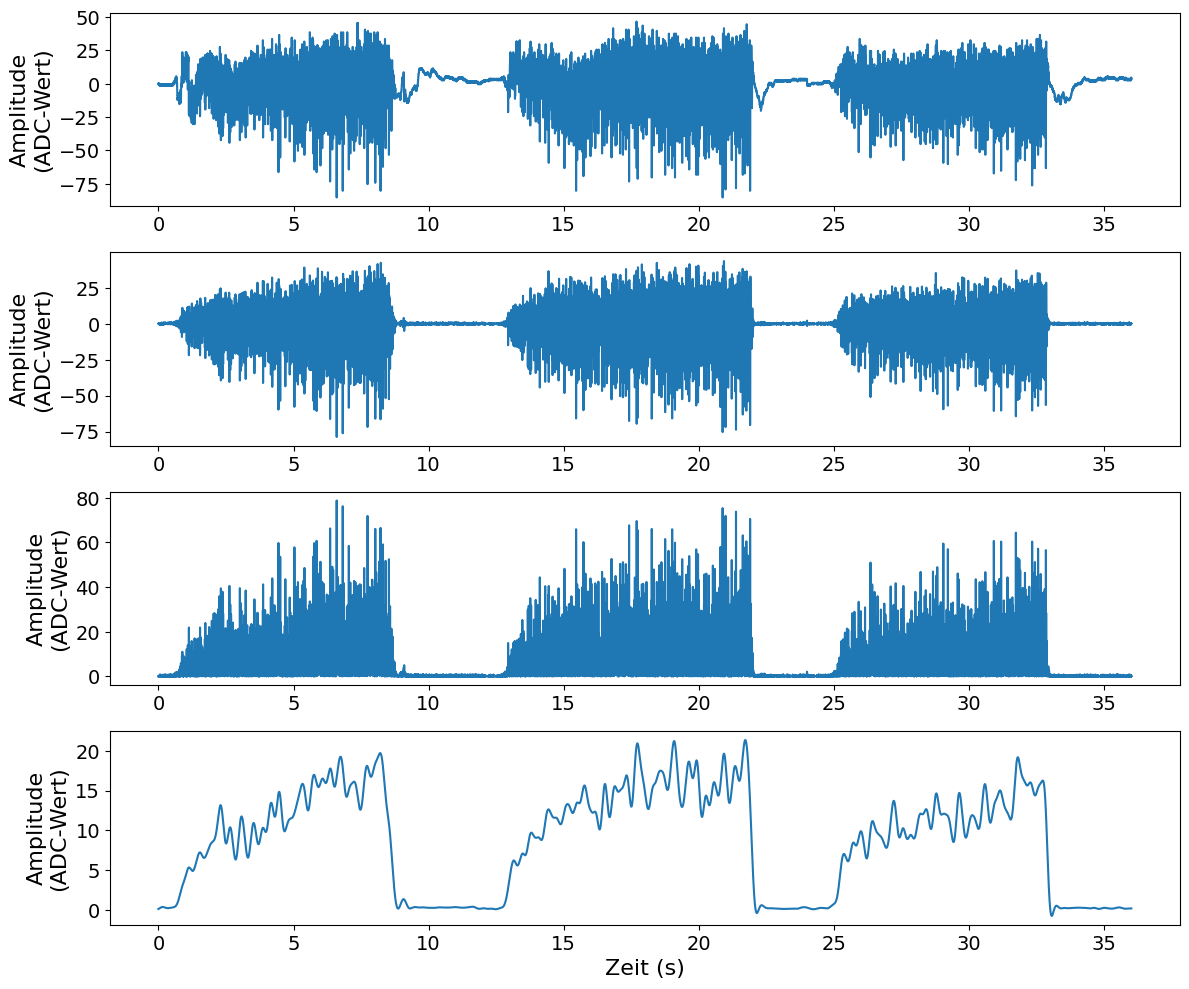

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import Lab3Functions as l3f

# 1. Daten laden
weights, mvc, fatigue = l3f.import_data(';')

mvc_signal = (mvc['emg'].values)
weight_signal = (weights['emg'].values)
fatigue_signal = (fatigue['emg'].values)

real_duration = 12.001 * 3 

t_correct = np.linspace(0, real_duration, len(mvc))

fs = len(mvc) / real_duration
print(f"Abtastrate: {fs} Hz")

# --- FILTER FUNKTIONEN ---
def butter_bandpass(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def butter_lowpass(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    if normal_cutoff >= 1: normal_cutoff = 0.99
    b, a = signal.butter(order, normal_cutoff, btype='low')
    return signal.filtfilt(b, a, data)

def preprocess_emg(data_series, fs):
    no_offset = data_series - np.mean(data_series)
    # Bandpass
    filtered = butter_bandpass(no_offset, 20, 450, fs)
    # Gleichrichten
    rectified = np.abs(filtered)
    # Einhüllende (3 Hz)
    envelope = butter_lowpass(rectified, 3, fs)
    return filtered, envelope

# --- VERARBEITUNG ---
mvc_filt, mvc_env = preprocess_emg(mvc_signal, fs)
weight_filt, weight_env = preprocess_emg(weight_signal, fs)
fatigue_filt, fatigue_env = preprocess_emg(fatigue_signal, fs)

# --- PLOT MIT KORREKTER ZEITACHSE ---
plt.figure(figsize=(12, 10))

# Offset
plt.subplot(4, 1, 1)
plt.plot(t_correct, mvc_signal - np.mean(mvc_signal))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Amplitude\n(ADC-Wert)', fontsize=16)

# Filtered
plt.subplot(4, 1, 2)
plt.plot(t_correct, mvc_filt)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Amplitude\n(ADC-Wert)', fontsize=16)

# Rectified
plt.subplot(4, 1, 3)
plt.plot(t_correct, np.abs(mvc_filt))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Amplitude\n(ADC-Wert)', fontsize=16)

# Envelope
plt.subplot(4, 1, 4)
plt.plot(t_correct, mvc_env)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Amplitude\n(ADC-Wert)', fontsize=16)
plt.xlabel('Zeit (s)', fontsize=16)

plt.tight_layout()
plt.savefig("filtered_mvc.png")

In [ ]:
import matplotlib

# Am zuverlässigsten funktioniert ein interaktives Fenster mit Jupiternotebook mit einem PyQt5 Backend. Daher muss für die Auswahl Pyqt5 Installiert werden. -> pip install PyQt5
%matplotlib qt

# Falls das nicht funktioniert, kann der Auswahlteil auch einfach übersprungen werden, indem folgende variable auf True gesetzt wird. (Es werden von uns ausgewählte Standardparameter verwendet.):
skip_selection = False

# Anleitung:
# 1. Zoom in den ersten Burst. Drücke ENTER.
# 2. Klicke Startpunkt, Klicke Endpunkt.
# 3. Wiederhole für alle 3 Bursts pro Experiment (insgesamt 9x auswählen).

if not skip_selection:
    mvc_s, mvc_e, w_s, w_e, f_s, f_e = l3f.get_bursts(mvc_filt, weight_filt, fatigue_filt)
else:
    mvc_s, mvc_e = [2100, 31423, 61164], [20982, 53172, 79695]
    w_s, w_e = [2987, 33856, 75679], [21494, 53180, 81753]
    f_s, f_e = [4025, 83458, 167725], [67225,145514, 226610]

plt.close('all')

Click once to start zoom


KeyboardInterrupt: 

: 

[ 2100 31423 61164]
[20982 53172 79695]
[ 2987 33856 75679]
[21494 53180 81753]
[  4025  83458 167725]
[ 67225 145514 226610]
MVC Werte der 3 Versuche: [np.float64(12.213011155652696), np.float64(13.923848978690634), np.float64(11.534457675764248)]
Persönlicher MVC (Mittelwert): 12.5571

--- Experiment 2: Gewichte ---
Gewicht Leicht (~25%): 18.67 % MVC
Gewicht Mittel (~50%): 33.01 % MVC
Gewicht Schwer (~75%): 136.16 % MVC


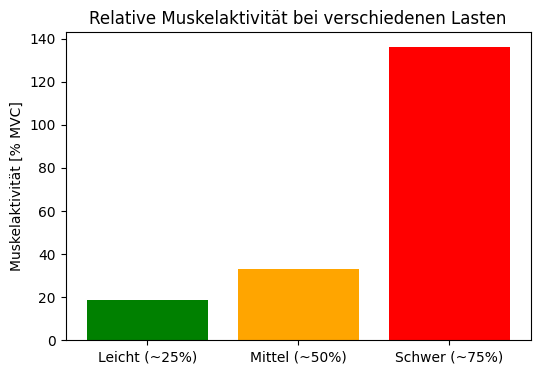

In [ ]:
%matplotlib inline

print(mvc_s)
print(mvc_e)

print(w_s)
print(w_e)

print(f_s)
print(f_e)

def calc_mean_activity(envelope, start_idx, end_idx):
    segment = envelope[start_idx:end_idx]
    return np.mean(segment)

# Calculate MVC
mvc_values = []
for i in range(3):
    val = calc_mean_activity(mvc_env, mvc_s[i], mvc_e[i])
    mvc_values.append(val)

personal_mvc = np.mean(mvc_values)
print(f"MVC Werte der 3 Versuche: {mvc_values}")
print(f"Persönlicher MVC (Mittelwert): {personal_mvc:.4f}")

# Relative Activity Weights
weight_percentages = []
for i in range(3):
    val = calc_mean_activity(weight_env, w_s[i], w_e[i])
    percent = (val / personal_mvc) * 100
    weight_percentages.append(percent)

print("\n--- Experiment 2: Gewichte ---")
weights_label = ["Leicht (~25%)", "Mittel (~50%)", "Schwer (~75%)"]
for lab, val in zip(weights_label, weight_percentages):
    print(f"Gewicht {lab}: {val:.2f} % MVC")

# Section 5
plt.figure(figsize=(6, 4))
plt.bar(weights_label, weight_percentages, color=['green', 'orange', 'red'])
plt.ylabel('Muskelaktivität [% MVC]')
plt.title('Relative Muskelaktivität bei verschiedenen Lasten')
plt.savefig('mvc_weights.png')

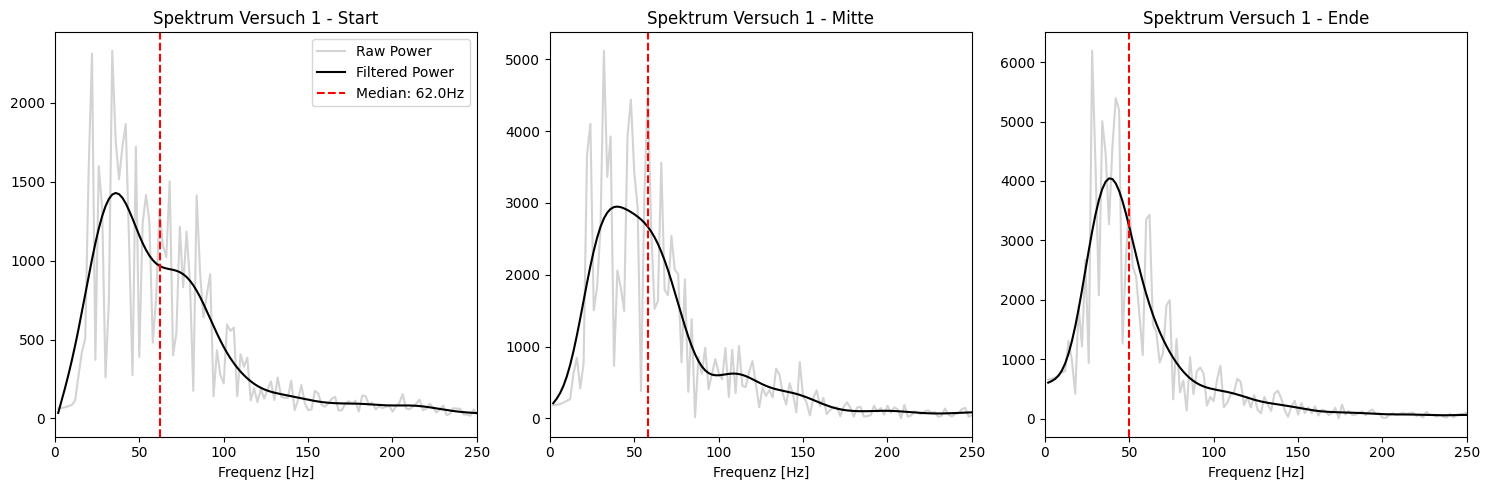

In [ ]:
import scipy

# 5. Frequenzanalyse bei Ermüdung (Aufgabe 6, 7, 8)
# Wir analysieren jeweils 0.5s am Anfang, in der Mitte und am Ende jedes Ermüdungs-Bursts.

WINDOW_SEC = 0.5
window_samples = int(WINDOW_SEC * fs)

# Speicher für die Median-Frequenzen (3 Versuche x 3 Zeitpunkte)
median_freq_results = np.zeros((3, 3)) # Zeilen: Versuche, Spalten: Start, Mitte, Ende

# Plot vorbereiten für eines der Spektren (Aufgabe 6)
plt.figure(figsize=(15, 5))

for i in range(3): # Über die 3 Ermüdungs-Versuche (Fatigue1, Fatigue2, Fatigue3)
    
    # Start und Ende des gesamten Bursts aus der manuellen Auswahl
    burst_start = f_s[i]
    burst_end = f_e[i]
    burst_len = burst_end - burst_start
    
    # Definition der 3 Zeitpunkte (Indizes)
    # Start: direkt am Anfang des Bursts
    idx_start = burst_start
    # Mitte: In der Mitte des Bursts
    idx_mid = burst_start + (burst_len // 2) - (window_samples // 2)
    # Ende: Kurz vor Ende des Bursts
    idx_end = burst_end - window_samples
    
    indices = [idx_start, idx_mid, idx_end]
    labels = ['Start', 'Mitte', 'Ende']
    
    for k, idx in enumerate(indices):
        # 0.5s Segment isolieren (NUR gefiltert, nicht gleichgerichtet!)
        segment = fatigue_filt[idx : idx + window_samples]
        
        # Power Spectrum berechnen (l3f Funktion)
        power, freqs = l3f.get_power(segment, fs)
        
        # Spektrum glätten (Lowpass 40 Hz laut Angabe)
        # Wir nutzen hier die gleiche Lowpass Funktion, aber auf das Power-Signal angewendet
        power_smooth = butter_lowpass(power, 40, fs=len(power)*2, order=4) 
        # Hinweis: fs beim Glätten des Spektrums ist trickreich. 
        # Da Power ein Array über Frequenz ist, ist es hier eher eine "Glättung über Bins".
        # Einfacher und robuster für diese Aufgabe ist oft ein Moving Average, 
        # aber die Angabe fordert Butterworth. Wir nutzen eine angepasste Logik oder simple Glättung:
        # Alternativ: wir wenden den Filter direkt auf das Array an, nehmen an fs=SamplePoints.
        power_smooth = signal.filtfilt(*signal.butter(4, 0.1), power) # Simple smoothing
        
        # Median Frequenz berechnen (Code aus Angabe)
        area_freq = scipy.integrate.cumulative_trapezoid(power_smooth, freqs, initial=0)
        total_power = area_freq[-1]
        
        # Finde Index wo Fläche zur Hälfte voll ist
        idx_median = np.where(area_freq >= total_power / 2 )[0][0]
        med_freq = freqs[idx_median]
        
        median_freq_results[i, k] = med_freq
        
        # Plotten für den ersten Versuch (Aufgabe 6)
        if i == 0:
            plt.subplot(1, 3, k+1)
            plt.plot(freqs, power, color='lightgray', label='Raw Power')
            plt.plot(freqs, power_smooth, color='black', label='Filtered Power')
            plt.axvline(med_freq, color='red', linestyle='--', label=f'Median: {med_freq:.1f}Hz')
            plt.title(f'Spektrum Versuch 1 - {labels[k]}')
            plt.xlabel('Frequenz [Hz]')
            if k==0: plt.legend()
            plt.xlim(0, 250) # Meistens ist über 250Hz wenig los

plt.tight_layout()
plt.show()

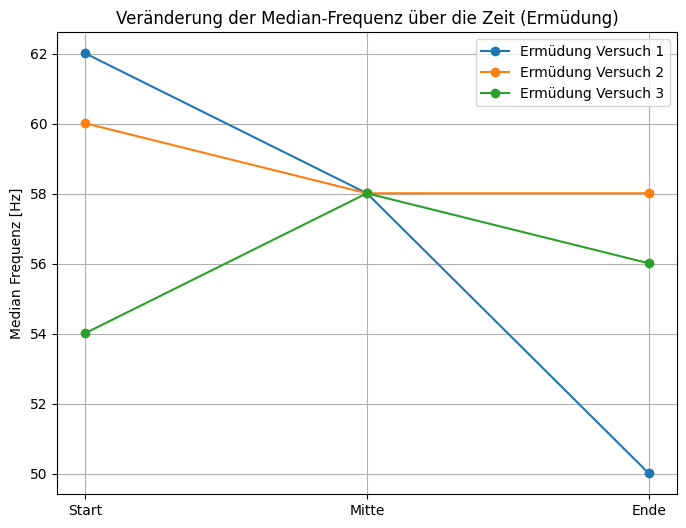

Median Frequenzen (Start, Mitte, Ende):
[[62.01398373 58.01308156 50.0112772 ]
 [60.01353264 58.01308156 58.01308156]
 [54.01217938 58.01308156 56.01263047]]


In [ ]:
# Median-Frequenz über die Zeit (Aufgabe 8)
# Plot der Veränderung der Medianfrequenz für alle 3 Versuche.

plt.figure(figsize=(8, 6))
time_points = ['Start', 'Mitte', 'Ende']

for i in range(3):
    plt.plot(time_points, median_freq_results[i, :], marker='o', label=f'Ermüdung Versuch {i+1}')

plt.title('Veränderung der Median-Frequenz über die Zeit (Ermüdung)')
plt.ylabel('Median Frequenz [Hz]')
plt.grid(True)
plt.legend()
plt.show()

# Ausgabe der Werte für den Bericht
print("Median Frequenzen (Start, Mitte, Ende):")
print(median_freq_results)